The number of hurricanes in 2005 is statistically significant.
T-statistic: 6.4347
Critical t-value: 2.2622
P-value: 0.0001
The change in blood pressures is statistically significant.


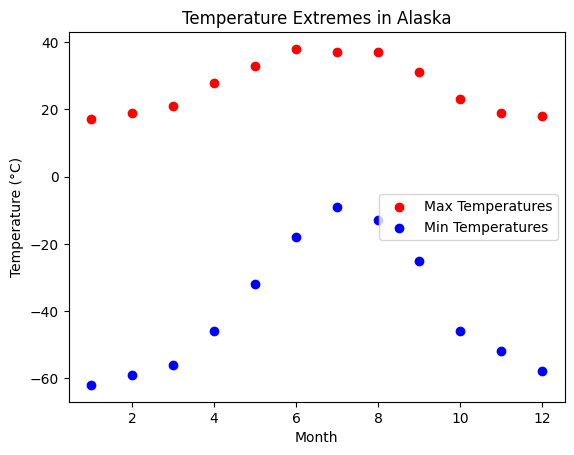

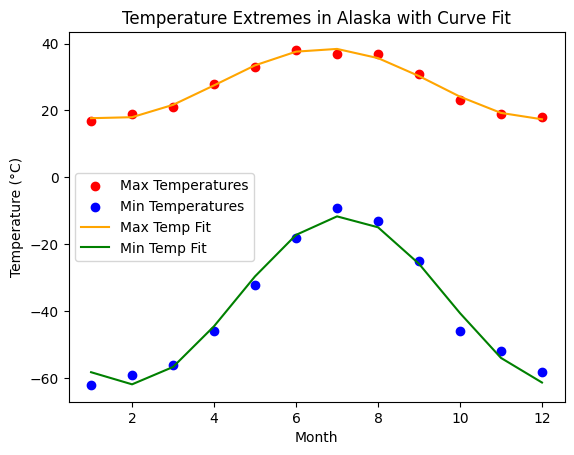

Time offset difference between max and min temperatures: -11.0587 months


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [35]:
import math
import numpy as np
import pandas as pd
from scipy.stats import t
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from scipy.optimize import curve_fit

# 1. Hurricanes per Year
historic_average = 6.3
number_of_hurricanes_2005 = 15
def poisson_pmf(lmbda, k):
    return math.exp(-lmbda) * (lmbda**k) / math.factorial(k)
probability_15_or_more = 1 - sum(poisson_pmf(historic_average, i) for i in range(number_of_hurricanes_2005))
alpha = 0.022
if probability_15_or_more < alpha:
    print(f"The number of hurricanes in 2005 is statistically significant.")
else:
    print(f"The number of hurricanes in 2005 is not statistically significant.")



# 2. Pairwise t-test
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
differences = post - pre
mean_difference = np.mean(differences)
std_dev_difference = np.std(differences, ddof=1)  # ddof=1 for sample standard deviation
n = len(differences)
t_statistic = mean_difference / (std_dev_difference / np.sqrt(n))
degrees_of_freedom = n - 1
alpha = 0.05
critical_t_value = t.ppf(1 - alpha / 2, degrees_of_freedom)
p_value = 2 * (1 - t.cdf(np.abs(t_statistic), degrees_of_freedom))
statistically_significant = p_value < alpha
print(f'T-statistic: {t_statistic:.4f}')
print(f'Critical t-value: {critical_t_value:.4f}')
print(f'P-value: {p_value:.4f}')
if statistically_significant:
    print('The change in blood pressures is statistically significant.')
else:
    print('The change in blood pressures is not statistically significant.')



# 3.Curve fitting of temperature in Alaska
months = np.arange(1, 13)
max_temps = np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
min_temps = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
plt.scatter(months, max_temps, label='Max Temperatures', color='red')
plt.scatter(months, min_temps, label='Min Temperatures', color='blue')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Extremes in Alaska')
plt.legend()
plt.show()

def temp_function(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(frequency * (x - phase)) + offset

p0 = [20, 0.5, 0, -40]
params_max, covariance_max = curve_fit(temp_function, months, max_temps, p0=p0)
params_min, covariance_min = curve_fit(temp_function, months, min_temps, p0=p0)
plt.scatter(months, max_temps, label='Max Temperatures', color='red')
plt.scatter(months, min_temps, label='Min Temperatures', color='blue')
plt.plot(months, temp_function(months, *params_max), color='orange', label='Max Temp Fit')
plt.plot(months, temp_function(months, *params_min), color='green', label='Min Temp Fit')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Extremes in Alaska with Curve Fit')
plt.legend()
plt.show()
offset_difference = params_max[2] - params_min[2]
print(f'Time offset difference between max and min temperatures: {offset_difference:.4f} months')




# 5. Temperatures in Munich

file_path = './data/munich_temperatures_average_with_bad_data.txt'
data = np.loadtxt(file_path, skiprows=1, usecols=(0, 1))
years = data[:, 0]
temperatures = data[:, 1]
mask = (years >= 2008) & (years <= 2012)
years_subset = years[mask]
temperatures_subset = temperatures[mask]
def f(t, a, b, c):
    return a * np.cos(2 * np.pi * t + b) + c

params, covariance = curve_fit(f, years_subset, temperatures_subset)

a_fit, b_fit, c_fit = params
a_err, b_err, c_err = np.sqrt(np.diag(covariance))

overall_avg_temperature = np.mean(temperatures)
daily_avg_coldest = f(0, a_fit, b_fit, c_fit)
daily_avg_hottest = f(0.5, a_fit, b_fit, c_fit)
plt.scatter(years, temperatures, label='Data')
plt.plot(years_subset, f(years_subset, a_fit, b_fit, c_fit), color='red', label='Best-Fit Model')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Temperature in Munich (2008-2012) and Best-Fit Model')
plt.legend()
plt.show()
print(f'Best-Fit Parameters:')
print(f'a = {a_fit:.4f} ± {a_err:.4f}')
print(f'b = {b_fit:.4f} ± {b_err:.4f}')
print(f'c = {c_fit:.4f} ± {c_err:.4f}')
print(f'Overall Average Temperature: {overall_avg_temperature:.4f} °C')
print(f'Typical Daily Average (Coldest): {daily_avg_coldest:.4f} °C')
print(f'Typical Daily Average (Hottest): {daily_avg_hottest:.4f} °C')


# 4. Fit the residues
file_path = './data/residuals_261.pkl'
data = pd.read_pickle(file_path)
residuals = data['residual'].values
bin_edges = np.linspace(min(residuals), max(residuals), 20)
hist, bin_edges = np.histogram(residuals, bins=bin_edges)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_errors = np.sqrt(hist)

plt.bar(bin_centers, hist, width=np.diff(bin_edges), color='blue', alpha=0.7, label='Residuals')
plt.errorbar(bin_centers, hist, yerr=bin_errors, fmt='none', color='black', capsize=2, label='Uncertainties')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.legend()
plt.show()
def gaussian(x, amplitude, mean, std_dev):
    return amplitude * np.exp(-(x - mean)**2 / (2 * std_dev**2))
p0 = [1, 0, 1]
params, covariance = curve_fit(gaussian, bin_centers, hist, p0=p0, sigma=bin_errors)
expected_counts = gaussian(bin_centers, *params)
chi2, p_value = chisquare(hist, f_exp=expected_counts, ddof=len(params))
print(f'Fit parameters: Amplitude={params[0]:.4f}, Mean={params[1]:.4f}, Standard Deviation={params[2]:.4f}')
print(f'Chi^2 value: {chi2:.4f}')
print(f'p-value of the fit: {p_value:.4f}')
if p_value < 0.05:
    print('The fit function is not appropriate to describe the data.')
else:
    print('The fit function is appropriate to describe the data.')


